# 1. Modules

## 1.1. Load basics

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
import sys
sys.path.append('../..')

## 1.2. Load library modules

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.misc.load import load_matlab_data
from magrec.transformation.Bxyz2Jxy import Bxyz2Jxy
from magrec.transformation.Bsensor2Jxy import Bsensor2Jxy
from magrec.transformation.MagneticFields import MagneticFields 
import magrec.misc.save as save


from magrec.misc.data import Data
from magrec import __datapath__

# 2. Data

## 2.1. Load Data¶

(55, 125)
(55, 125)
(110, 250)
Applied a high frequency filter, removing all components smaller than 0.05 um


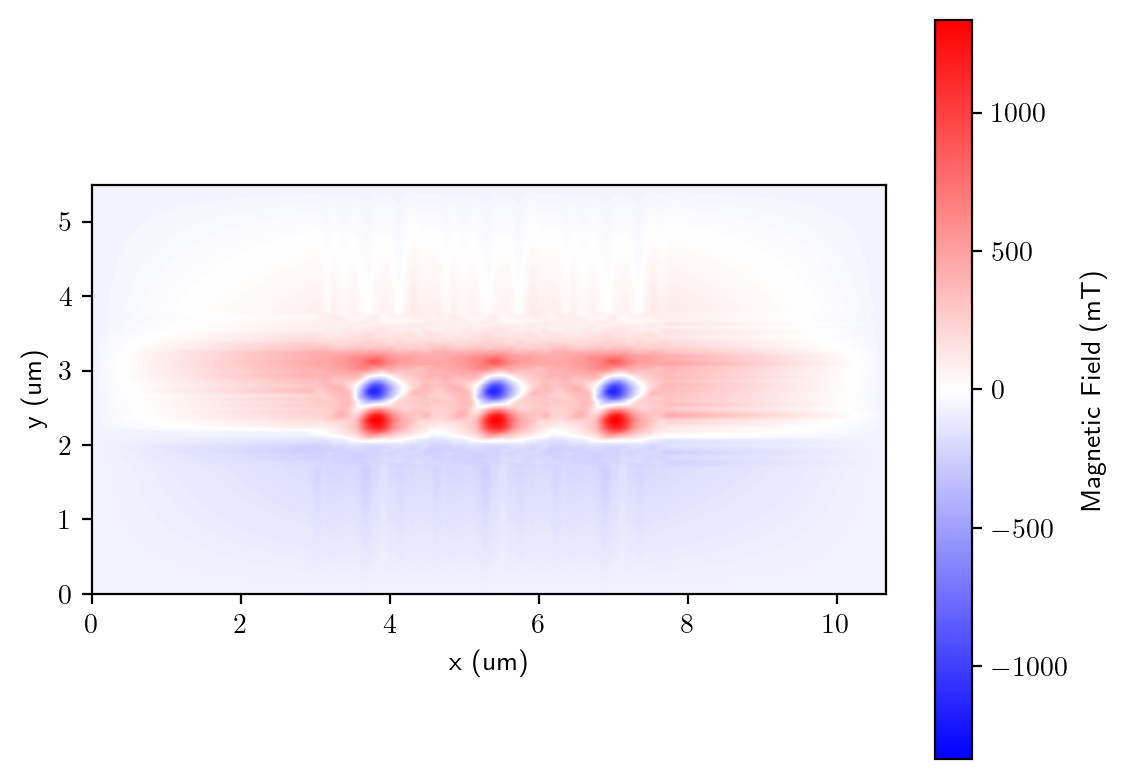

torch.Size([325, 365])


In [9]:
from scipy import interpolate

mat = load_matlab_data(__datapath__ / "experimental" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")
B_NV = mat['Bnv_map']

print(B_NV.shape)

x = np.linspace(0, B_NV.shape[1], B_NV.shape[1])
y = np.linspace(0, B_NV.shape[0], B_NV.shape[0])
xx, yy = np.meshgrid(x, y)

print(xx.shape)

f = interpolate.interp2d(x, y, B_NV, kind='cubic')
xnew =  np.linspace(0, B_NV.shape[1], int(2*B_NV.shape[1]))
ynew =  np.linspace(0, B_NV.shape[0], int(2*B_NV.shape[0]))

B_new = f(xnew, ynew)
print(B_new.shape)

B = B_NV * 1e3

B_smoothed = sp.ndimage.gaussian_filter(B, sigma=1)

B_NV = np.concatenate(((B_smoothed), B_smoothed, (B_smoothed)) )*1e3

B_NV = np.pad(B_NV,100, mode='linear_ramp')



sensor_theta = 35
sensor_phi = -145  +90

dy = 0.0169 
dx = 0.0292 
height = 0.01
thickness = 0.001

dataset = Data()
dataset.load_data(
       B_NV.T, 
       dx, 
       dy, 
       height, 
       sensor_theta, 
       sensor_phi, 
       thickness)

dataset.remove_DC_background()
dataset.add_hanning_filter(0.05)
dataset.add_short_wavelength_filter(0.05)

# dataset.crop_data((1,198,1,198))
# dataset.pad_data_to_power_of_two()
# dataset.pad_reflective2d()
dataset.plot_target()


print(dataset.target.shape)

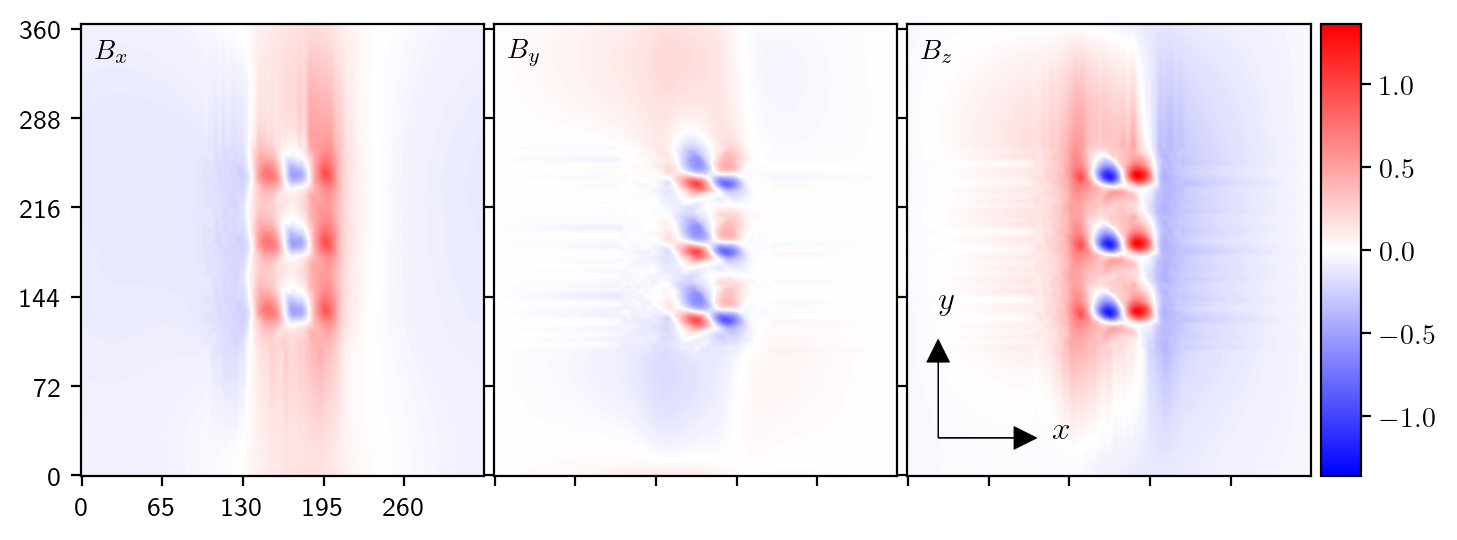

In [10]:
# check the orintation
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

Text(0.5, 1.0, 'Jy')

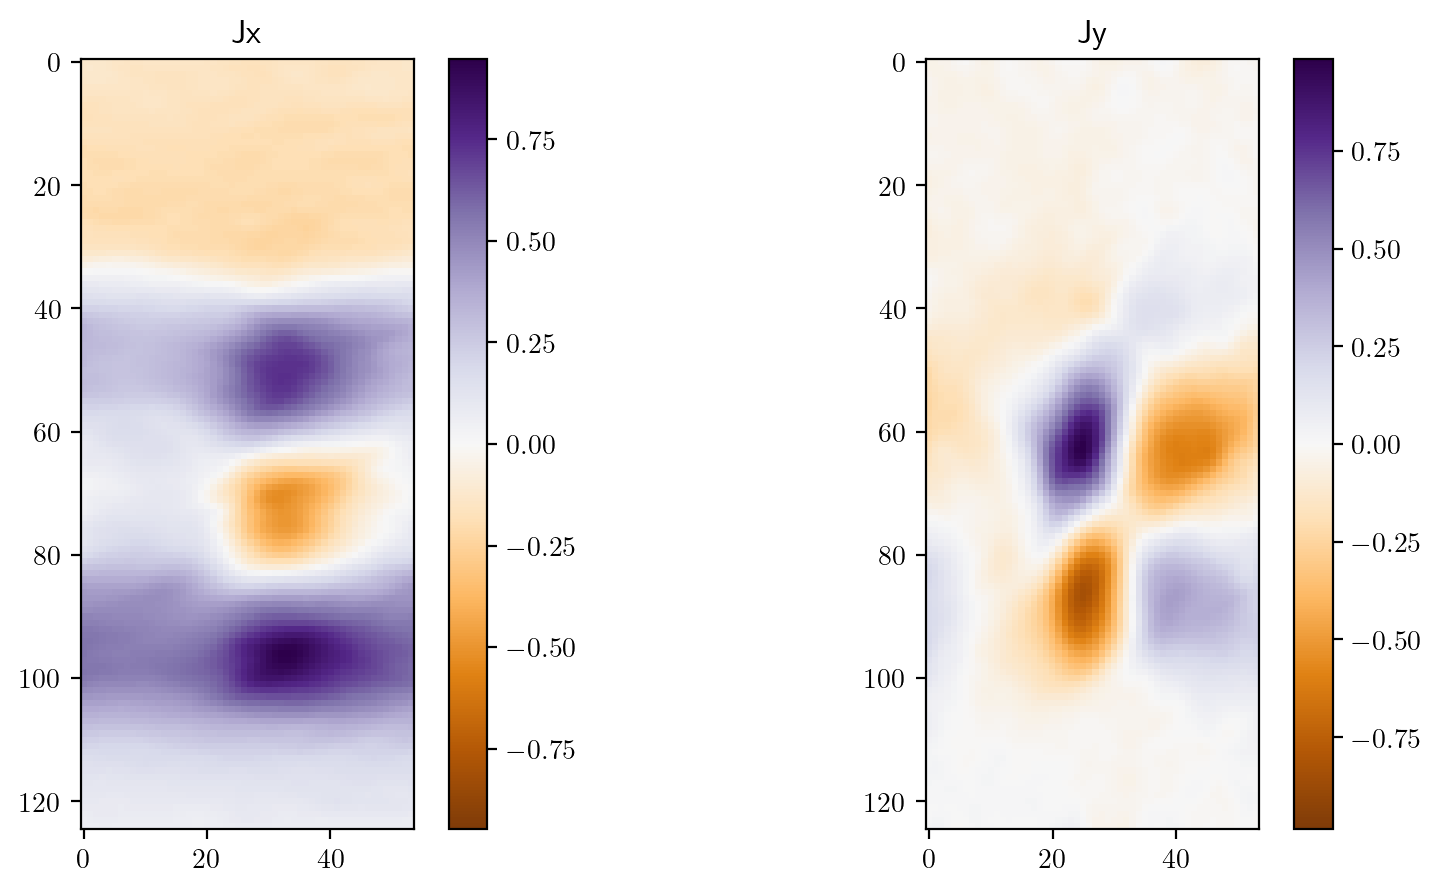

In [11]:

fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.subplot(1,2,1)
plot_data = dataset.transformed_target[0,100:-100,155:-155]
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jx")

plt.subplot(1,2,2)
plot_data = dataset.transformed_target[1,100:-100,155:-155]
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jy")

In [137]:
# check the actions that have been applied to the dataset
dataset.actions

,action type,reverseable,reverse action,description,parameters
0,load_data,False,None,loaded the data,None
1,remove_DC_background,False,None,Removed the DC background from the data,None
2,hanning_filter,False,None,"Applied a low frequency filter, removing all c...",wavelength = 0.1
3,short_wavelength_filter,False,None,"Applied a high frequency filter, removing all ...",wavelength = 0.1


# Fourier method reconstruction

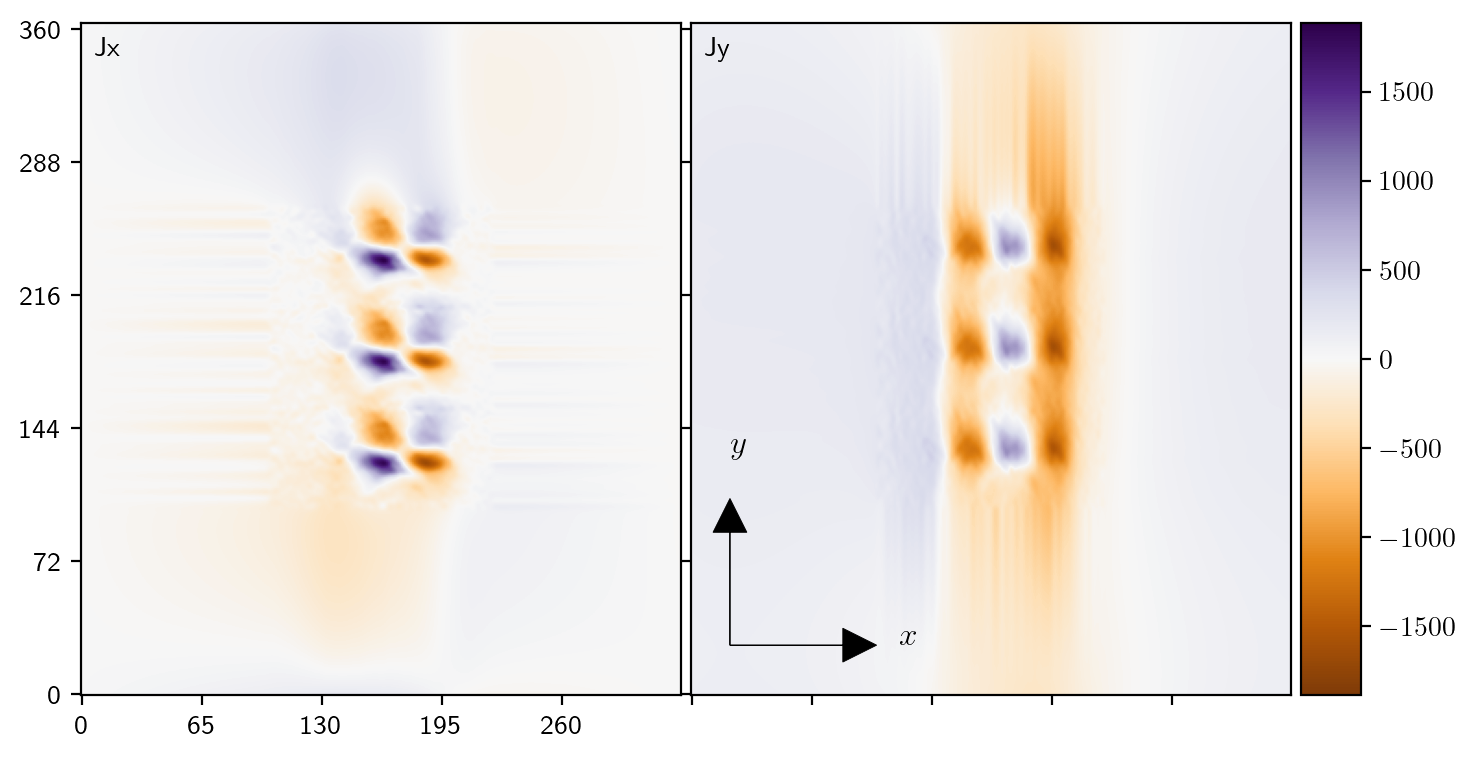

In [12]:
dataset2 = copy.deepcopy(dataset)

dataset2.target = dataset2.transformed_target

dataset2.set_transformer(Bxyz2Jxy)
dataset2.transform_data()


plot_n_components(
    dataset2.transformed_target, 
    symmetric=True, 
    labels=["Jx", "Jy"], 
    cmap="PuOr")


## Reconstruct the current density using a neural network using Bz data

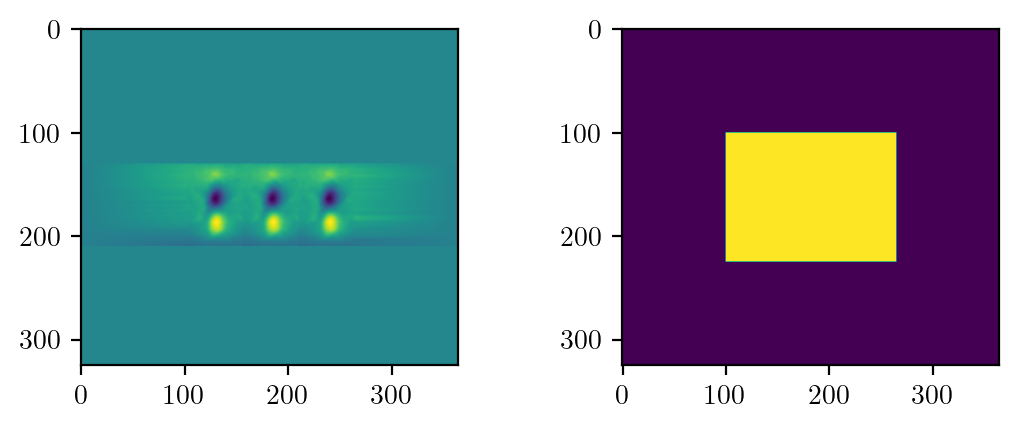

In [195]:
from magrec.method.FCNN import FCNN
from magrec.models.Jxy import Jxy

import magrec.image_processing.Masks as Masks
weight1 = Masks.mask_vert_dir(dataset.target, 1e-5,  plot=False)

loss_weight = torch.zeros(dataset.target.shape)
loss_weight[100:-100,100:-100] = 1

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = weight1
# weight[::,0:100] = 0 
# weight[::,-100::] = 0 
weight[0:130,::] = 0 
weight[-115::,::] = 0 

plt.figure()
plt.subplot(2,2,1)
plt.imshow(dataset.target * weight)

plt.subplot(2,2,2)
plt.imshow(weight)

plt.subplot(2,2,2)
plt.imshow(loss_weight)


In [196]:
Model = Jxy(dataset, "MSE",  std_loss_scaling = 1)
FittingMethod = FCNN(Model, dataset)
FittingMethod.prepare_fit(loss_weight=loss_weight)
# FittingMethod.prepare_fit()

Number of sources: 2
Number of targets: 1


C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 325, 365])) that is different to the input size (torch.Size([1, 325, 365])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  2.22e+10
epoch    11 | loss on last mini-batch:  2.20e+10
epoch    21 | loss on last mini-batch:  1.44e+10
epoch    31 | loss on last mini-batch:  2.30e+09
epoch    41 | loss on last mini-batch:  1.40e+09
epoch    51 | loss on last mini-batch:  9.32e+08
epoch    61 | loss on last mini-batch:  5.68e+08
epoch    71 | loss on last mini-batch:  5.57e+08
epoch    81 | loss on last mini-batch:  4.88e+08
epoch    91 | loss on last mini-batch:  4.75e+08
epoch   101 | loss on last mini-batch:  4.59e+08
epoch   111 | loss on last mini-batch:  4.48e+08
epoch   121 | loss on last mini-batch:  4.41e+08
epoch   131 | loss on last mini-batch:  4.35e+08
epoch   141 | loss on last mini-batch:  4.29e+08
epoch   151 | loss on last mini-batch:  4.25e+08
epoch   161 | loss on last mini-batch:  4.21e+08
epoch   171 | loss on last mini-batch:  4.18e+08
epoch   181 | loss on last mini-batch:  4.15e+08
epoch   191 | loss on last mini-batch:  4.13e+08
epoch   201 | loss o

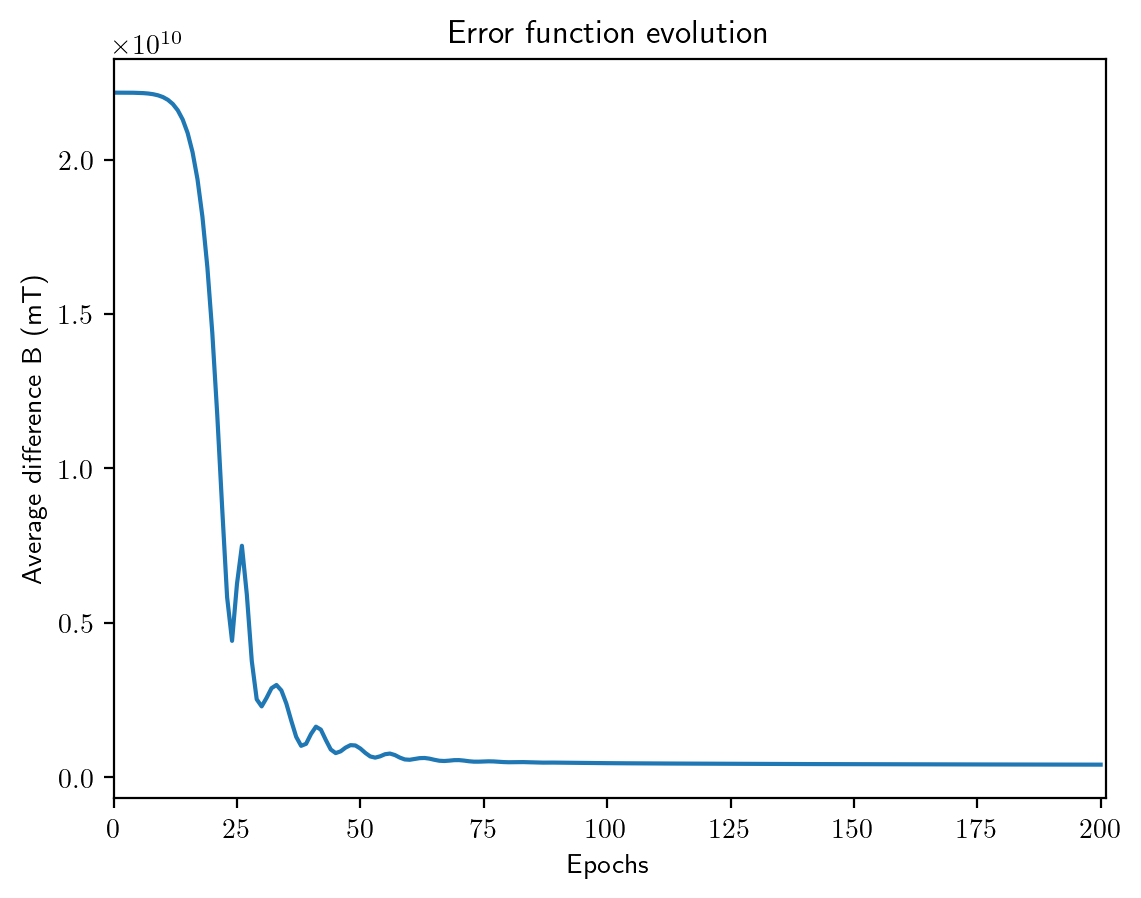

In [197]:
FittingMethod.fit(n_epochs=201, weight=weight)
# FittingMethod.fit(n_epochs=100)

FittingMethod.plot_loss()

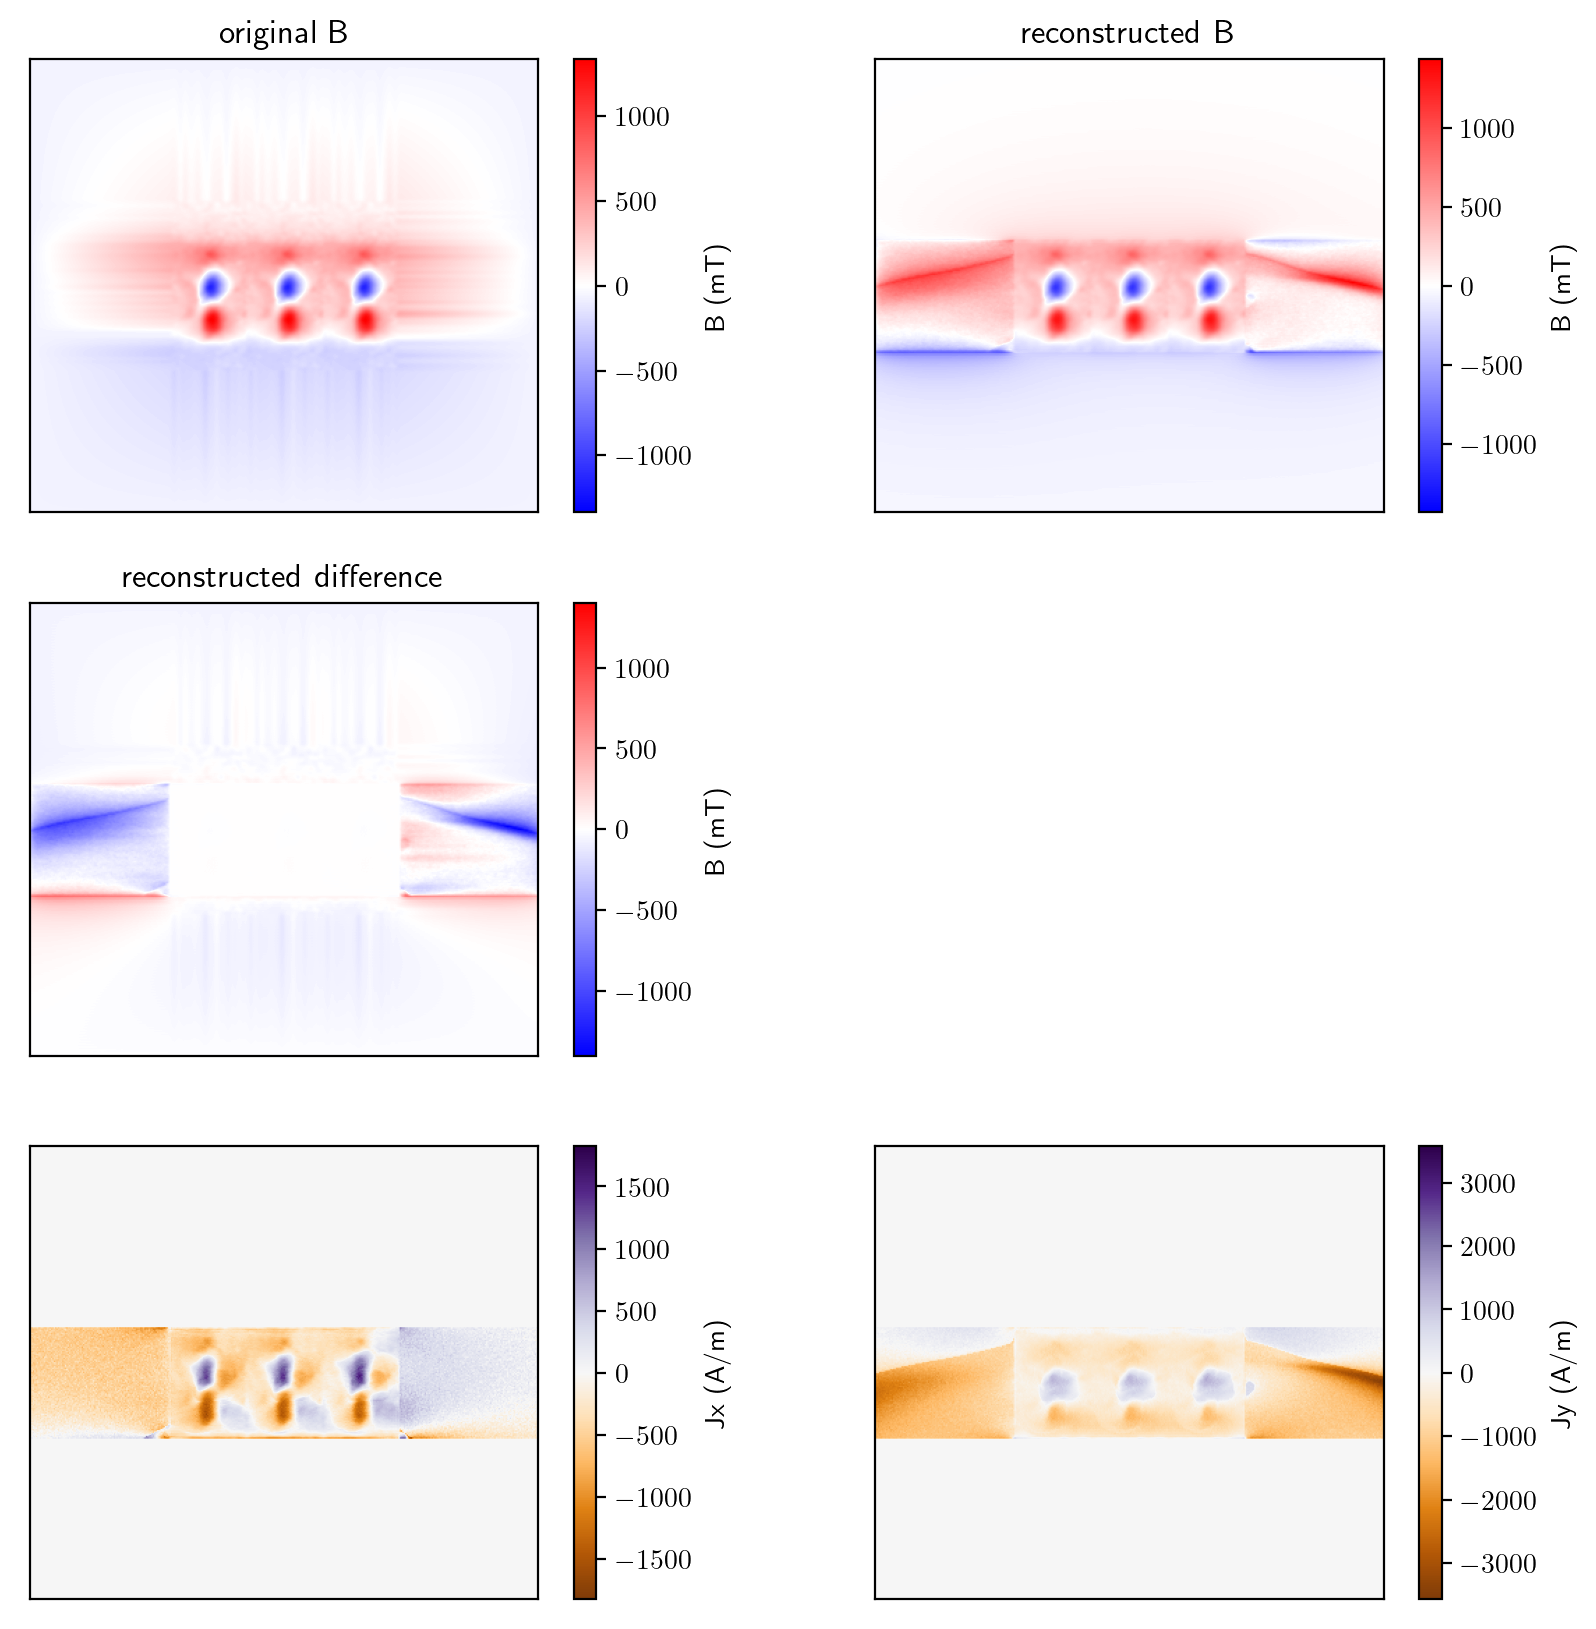

In [198]:
FittingMethod.extract_results(remove_padding=False)
FittingMethod.plot_results()

Text(0.5, 1.0, 'Jy')

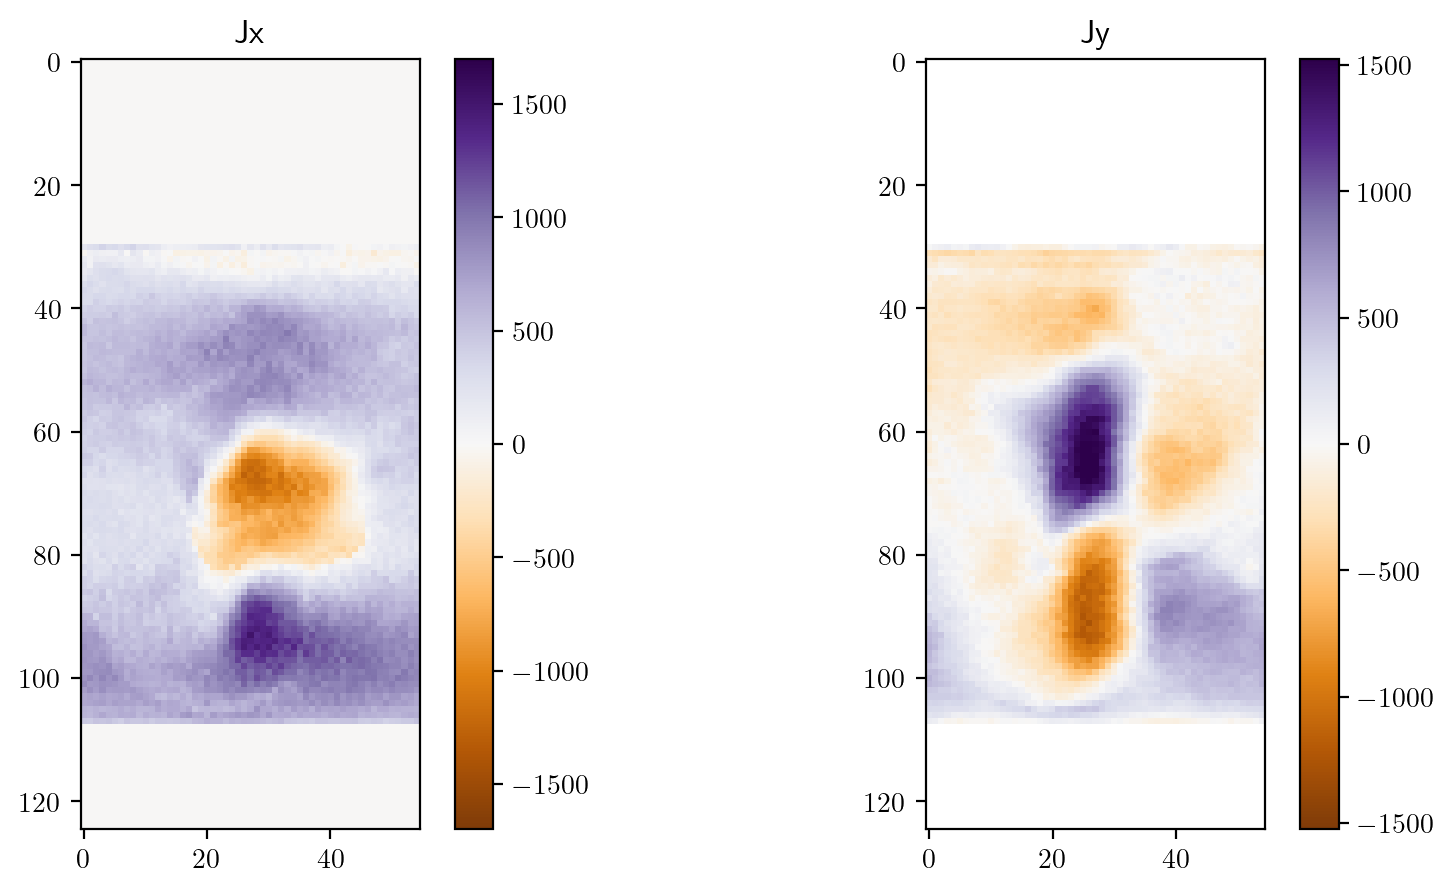

In [201]:
# Remove Jx background
FittingMethod.extract_results(remove_padding=False)
Results = dict()

plot_data_jx = FittingMethod.model.results['Jx'][100:-100,155:-155]
plot_data_jx[-17::,::] = 0
plot_data_jx[plot_data_jx==0] = np.nan
plot_data_jx = plot_data_jx + 250
plot_data_jx[plot_data_jx==np.nan] = 0

plot_data_jy = FittingMethod.model.results['Jy'][100:-100,155:-155]
plot_data_jy[-17::,::] = 0

Results['jx'] = plot_data_jx.tolist()
Results['jy'] =  plot_data_jy.tolist()
Results['recon B']  =  FittingMethod.model.results['Recon B'][100:-100,155:-155].tolist()
Results['original B']  =  FittingMethod.model.results['original B'].tolist()

fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(1,2,1)

plot_range = np.nanmax(np.abs(plot_data_jx.numpy()))
plt.imshow(plot_data_jy*-1, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jx")

plt.subplot(1,2,2)

plot_range = np.nanmax(np.abs(plot_data_jy.numpy()))
plt.imshow(plot_data_jx, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jy")

In [137]:
save.dict_2_json(" FCNN_reconstruction", Results)

serialize NumPy array into JSON and write into a file
Done writing serialized NumPy array into file


# Reconstruction with a CNN architecture

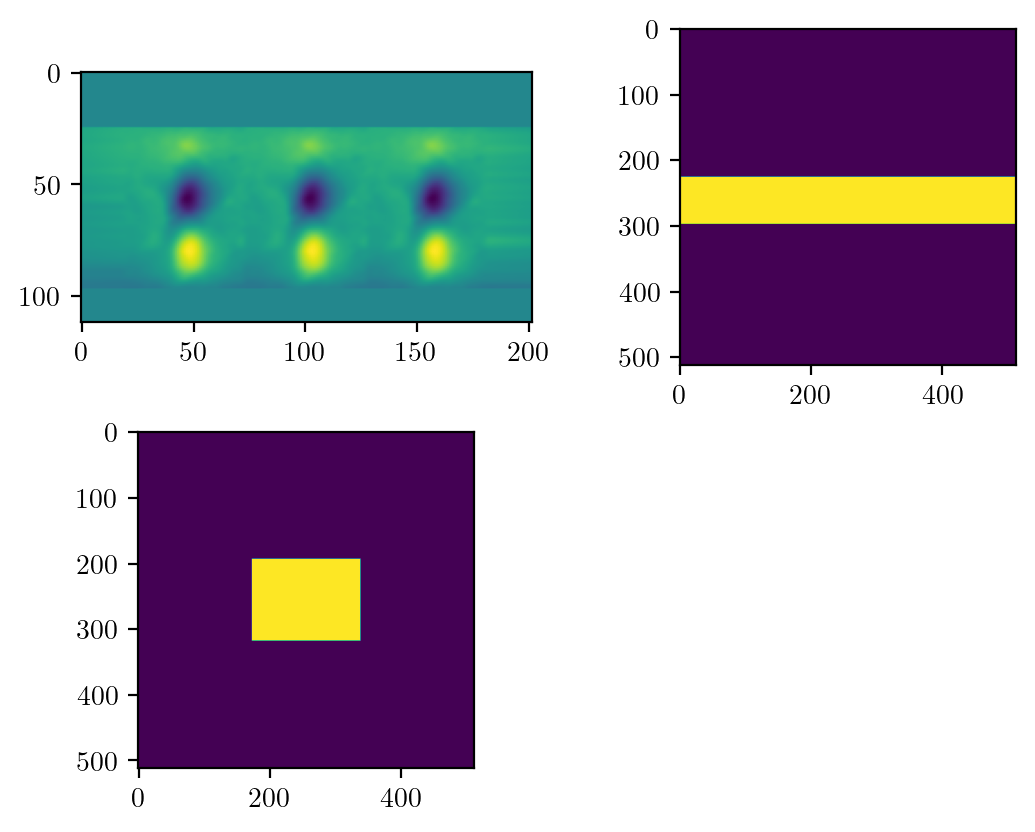

In [206]:
from magrec.method.CNN import CNN
from magrec.models.Jxy import Jxy
from magrec.image_processing.Padding import Padder
import magrec.image_processing.Masks as Masks

dataset3 = copy.deepcopy(dataset)
dataset3.target = dataset3.target*1e-2

padder = Padder()
loss_weight = torch.zeros(dataset3.target.shape)
loss_weight[100:-100,100:-100] = 1
loss_weight, _ = padder.pad_to_next_power_of_2(loss_weight)


_  = dataset3.pad_data_to_power_of_two()
weight1 = Masks.mask_vert_dir(dataset3.target, 1e-4,  plot=False)

# weight2 = Masks.mask_vert_dir(dataset2.target, 0.00001,  plot=True)
weight = torch.ones(dataset3.target.shape)
weight[0:225,::] = 0 
weight[-215::,::] = 0 
# weight[::,180::] = 0 


plt.figure()
plt.subplot(2,2,1)
plt.imshow((dataset3.target * weight)[200:-200,155:-155])

plt.subplot(2,2,2)
plt.imshow(weight)


plt.subplot(2,2,3)
plt.imshow(loss_weight)



In [207]:
Model = Jxy(dataset3, "MSE", std_loss_scaling = 0.1)
FittingMethod = CNN(Model, dataset3)
FittingMethod.prepare_fit(loss_weight=weight)

FittingMethod.fit(n_epochs=201, weight=weight)
# FittingMethod.fit(n_epochs=100)
FittingMethod.plot_loss()

Number of sources: 2
Number of targets: 1


C:\Users\parax\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1, 512, 512])) that is different to the input size (torch.Size([1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch     1 | loss on last mini-batch:  1.14e+06
epoch    11 | loss on last mini-batch:  4.89e+05
epoch    21 | loss on last mini-batch:  4.25e+05
epoch    31 | loss on last mini-batch:  3.27e+05
epoch    41 | loss on last mini-batch:  2.94e+05


In [ ]:
FittingMethod.extract_results(remove_padding=True)
FittingMethod.plot_results()

AttributeError: 'CNN' object has no attribute 'final_output'

In [ ]:
# Remove high frequency noise
from magrec.image_processing.Filtering import DataFiltering

Filter1 = DataFiltering(FittingMethod.model.results['Jx'][100:-100,155:-155], dx=dx, dy=dy)

Jx_smoothed = Filter1.apply_hanning_filter(0.02)
Jx_smoothed = Filter1.apply_short_wavelength_filter(0.02)

Filter2 = DataFiltering(FittingMethod.model.results['Jy'][100:-100,155:-155], dx=dx, dy=dy)

Jy_smoothed = Filter2.apply_hanning_filter(0.02)
Jy_smoothed = Filter2.apply_short_wavelength_filter(0.02)

fig = plt.figure() 
fig.set_size_inches(10, 5)
plt.subplot(1,2,1)
plot_data = Jx_smoothed
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jx")

plt.subplot(1,2,2)
plot_data = Jy_smoothed 
plot_range = np.max(np.abs(plot_data.numpy()))
plt.imshow(plot_data, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jy")

AttributeError: 'Jxy' object has no attribute 'results'

In [205]:
# Remove Jx background
FittingMethod.extract_results(remove_padding=True)
Results = dict()

plot_data_jx = FittingMethod.model.results['Jx'][100:-100,155:-155]
plot_data_jx[-17::,::] = 0
plot_data_jx[plot_data_jx==0] = np.nan
plot_data_jx = plot_data_jx + 5
plot_data_jx[plot_data_jx==np.nan] = 0

plot_data_jy = FittingMethod.model.results['Jy'][100:-100,155:-155]
plot_data_jy[-17::,::] = 0

Results['jx'] = plot_data_jx.tolist()
Results['jy'] =  plot_data_jy.tolist()
Results['recon B']  =  FittingMethod.model.results['Recon B'][100:-100,155:-155].tolist()
Results['original B']  =  FittingMethod.model.results['original B'].tolist()

fig = plt.figure()
fig.set_size_inches(10, 3)
plt.subplot(1,2,1)

plot_range = np.nanmax(np.abs(plot_data_jx.numpy()))
plt.imshow(plot_data_jy, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jx")

plt.subplot(1,2,2)

plot_range = np.nanmax(np.abs(plot_data_jy.numpy()))
plt.imshow(plot_data_jx, cmap="PuOr", vmin=-plot_range, vmax=plot_range)
plt.colorbar()
plt.title("Jy")

AttributeError: 'CNN' object has no attribute 'final_output'

In [163]:
save.dict_2_json(" CNN_reconstruction", Results)

serialize NumPy array into JSON and write into a file
Done writing serialized NumPy array into file
